<h2 style="text-align: center;">Brief Overview of the Analysis</h2>



This work is part of the micromobility project I worked on in Fall 2022 and Spring 2023. 

### Objective
The objective of this study was to predict the factors such as socioeconomic and demographic characteristics, attitudes, and land use patterns associated with e-scooter use frequency in South Florida region (Miami-Dade, Broward, and Palm Beach counties) using machine learning. 

### Data
Data from two different sources were used in this analysis. 
* Survey data: Individuals socioeconomic and demographic, attitudes on e-scooter and other mobility options, and stated preferences from different scenarios (this part was not used in this analysis) were collected by conducting an online stated preference survey using the Qualtrics platform. 

* Land use data: I obtained the land use data from Environmental Protection Agency's Smart Location Database (SLD).

### Data processing and analysis 
* Initially the survey data was processed using SPSS.
* SLD contains variables at the census block group (CBG) level while the survey collected zip code of the respondent's  residential location. I used the U.S. Census five-digit zip code tabulation areas based on census blocks to join the land use and survey data using ArcGIS.


#### _Step 1: Factor analysis_

* In the survey, the respondents were asked to answer 13 attitudinal questions in 5-point Likert scale about e-scooters benefits, existing e-scooter infrastructure, mobility preferences (e.g., private vehicle, alternative modes, etc.). Each respondent was asked to select one option for each statement that best fit their attitudes about those statements. 
* Applied __exploratory factor analysis (EFA)__ to identify the underlying factors in the attitudinal statements. 
    * The number of factors was determined based on the eigenvalue (eigenvalue > 1).
    * Several measures were checked to determine the suitability of the dataset. For example, __Kaiser-Meyer-Olkin (KMO)__ test was performed to check the sampling adequacy. (KMO >= 0.8 indicates the sampling is adequate).
    * Factor loading values were used to determine the correlation of the original statements with the identified latent factors. 
    * Identified latent factors (used the factor scores) were used as explanatory variables.


 #### _Step 2: Machine learning model_


* Applied the __recursive feature elimination (RFE)__ with a 10-fold cross-validation approach to reduce the dimensionality and make less complex model.
* Developed machine learning algorithm.
* Used __SHAP summary plot__ for feature importance and interpretation.

In addition, some __exploratory data analyses (EDA)__ were performed.

# Step 1: Factor Analysis

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [3]:
## Read data
F1 = pd.read_csv("attitudes.csv")
F1.head()

,escooter_1,escooter_2,escooter_3,escooter_4,escooter_5,escooter_6,mobility_1,mobility_2,mobility_3,mobility_4,mobility_5,mobility_6,mobility_7
0,4,4,4,4,4,5,3,5,4,4,5,3,4
1,5,3,3,5,5,3,5,3,3,4,5,1,3
2,5,5,5,5,5,5,5,1,5,5,5,1,5
3,5,5,5,5,5,5,3,5,5,4,5,5,5
4,3,5,5,5,5,3,3,5,3,5,5,1,3


In [4]:
F1.columns

Index(['escooter_1', 'escooter_2', 'escooter_3', 'escooter_4', 'escooter_5',
       'escooter_6', 'mobility_1', 'mobility_2', 'mobility_3', 'mobility_4',
       'mobility_5', 'mobility_6', 'mobility_7'],
      dtype='object')

In [5]:
# Convert column names to a list
column_names = F1.columns.tolist()

# Print all column names individually
for column_name in column_names:
    print(column_name)

escooter_1
escooter_2
escooter_3
escooter_4
escooter_5
escooter_6
mobility_1
mobility_2
mobility_3
mobility_4
mobility_5
mobility_6
mobility_7


In [6]:
####Dropping unnecessary columns

#F1.drop(['x', 'y'], axis=1,inplace=True)

In [7]:
####Droping missing values rows

F1.dropna(inplace=True)

In [8]:
F1.describe()

,escooter_1,escooter_2,escooter_3,escooter_4,escooter_5,escooter_6,mobility_1,mobility_2,mobility_3,mobility_4,mobility_5,mobility_6,mobility_7
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,3.392157,3.272059,3.186275,3.686275,3.674020,3.406863,2.627451,3.987745,2.958333,3.276961,4.200980,2.620098,3.963235
std,1.111980,1.180099,1.214008,1.065246,1.027442,1.122104,1.282439,1.031374,1.265971,1.168488,0.910652,1.328311,0.971901
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,4.000000,1.000000,3.000000
50%,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,2.000000,4.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


#### Exploratory Factor Analysis

In [13]:
###Adequecy test_Bartlett test (p-value < 0.05 indicates that the variances are significantly different)

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
calculate_bartlett_sphericity(F1)

(1829.3919527316068, 0.0)

In [14]:
###Kaiser-Meyer-Olkin (KMO) test to measure of how suited the data is for Factor Analysis 
###KMO values >= 0.8 indicate the sampling is adequate.
#https://www.statisticshowto.com/kaiser-meyer-olkin/ 

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model=calculate_kmo(F1)

In [15]:
kmo_model  

0.8056641564132593

In [16]:
# #create factor analysis object and perform factor analysis
# fa = FactorAnalyzer()
# fa.analyze(F1, 25, rotation = None)

# #check eigenvalues
# ev, v = fa.get_eigenvalues()
# ev

In [17]:
# import seaborn as sns

# plt.figure(figsize=(30,20))
# sns.heatmap(dataset.corr(), annot=True)

In [18]:
## correlation

corr = F1.corr()
corr.style.background_gradient(cmap='coolwarm')

,escooter_1,escooter_2,escooter_3,escooter_4,escooter_5,escooter_6,mobility_1,mobility_2,mobility_3,mobility_4,mobility_5,mobility_6,mobility_7
escooter_1,1.000000,0.556974,0.528176,0.616456,0.525074,0.521628,0.306009,0.104892,0.264713,0.254688,0.201008,0.142698,0.027014
escooter_2,0.556974,1.000000,0.705422,0.511736,0.452265,0.478411,0.224615,0.095606,0.288835,0.205367,0.150190,0.218137,0.055871
escooter_3,0.528176,0.705422,1.000000,0.527878,0.458524,0.514180,0.257733,0.056772,0.315205,0.299559,0.126069,0.229876,0.030807
escooter_4,0.616456,0.511736,0.527878,1.000000,0.723476,0.530486,0.225381,0.038983,0.194339,0.143013,0.214594,0.070104,-0.008795
escooter_5,0.525074,0.452265,0.458524,0.723476,1.000000,0.558603,0.217147,0.065780,0.180318,0.169528,0.280275,0.099869,0.061784
escooter_6,0.521628,0.478411,0.514180,0.530486,0.558603,1.000000,0.260965,0.093486,0.259298,0.217419,0.162632,0.270449,0.025014
mobility_1,0.306009,0.224615,0.257733,0.225381,0.217147,0.260965,1.000000,-0.311822,0.442913,0.359239,0.087413,0.264317,-0.011016
mobility_2,0.104892,0.095606,0.056772,0.038983,0.065780,0.093486,-0.311822,1.000000,-0.036146,0.041560,0.198829,0.122135,0.301039
mobility_3,0.264713,0.288835,0.315205,0.194339,0.180318,0.259298,0.442913,-0.036146,1.000000,0.433024,0.032856,0.255024,-0.009236
mobility_4,0.254688,0.205367,0.299559,0.143013,0.169528,0.217419,0.359239,0.041560,0.433024,1.000000,0.190008,0.148690,0.065239


In [19]:
### Factor analysis with 'varimax' rotation

fa = FactorAnalyzer(rotation = 'varimax')
fa.fit(F1)
fa.loadings_

fa = FactorAnalyzer()
fa.fit(F1)
eigen_values, vectors = fa.get_eigenvalues()

In [20]:
# fa.corr_

In [21]:
# fa.rotation_matrix_

In [22]:
### Communalities scores
### the proportion of each variable's variance that can be explained by the factors
### a variable that doesn't have any unique variance at all has a communality of 1

fa.get_communalities()

array([0.49768794, 0.41096364, 0.41674385, 0.96763658, 0.73156719,
       0.4090551 , 0.4893154 , 0.8137097 , 0.47596121, 0.30663828,
       0.10149595, 0.19108072, 0.1537772 ])

In [23]:
#Calculate eigenvalues

ev, v=fa.get_eigenvalues()
ev

array([4.34062033, 1.65694321, 1.40378116, 1.15156866, 0.83363911,
       0.68694189, 0.57110146, 0.53918544, 0.4954066 , 0.44343441,
       0.35087502, 0.28436728, 0.24213544])

Four latent variables have eigenvalues > 4, so the number of identified latent factors are 4

In [24]:
#array to csv output
# DF = pd.DataFrame(ev)
# DF.to_csv("eigenvalue.csv")

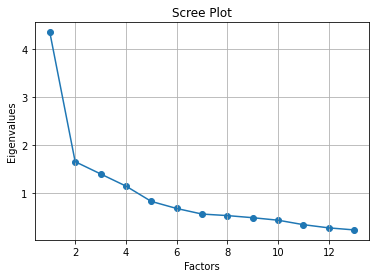

In [25]:
#Create scree plot using matplotlib

plt.scatter(range(1, F1.shape[1]+1),ev)
plt.plot(range(1,F1.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.grid()
plt.show()

In [26]:
### factor loadings of the identied factors
fa = FactorAnalyzer(4, rotation = "varimax")
fa.fit(F1)
loadings = fa.loadings_

In [27]:
#Factor loadings

pd.DataFrame.from_records(loadings)

,0,1,2,3
0,0.702851,0.224810,0.054724,0.053619
1,0.692028,0.214342,0.114202,-0.132169
2,0.692586,0.276348,0.080969,-0.143892
3,0.834581,0.036786,-0.074125,0.164046
4,0.746639,0.080681,0.014048,0.213377
5,0.661370,0.218516,0.081245,-0.045650
6,0.194945,0.684813,-0.251350,0.034622
7,0.096915,-0.152149,0.751904,-0.018362
8,0.201024,0.618036,0.005425,-0.102710
9,0.150112,0.565784,0.121503,0.089885


In [28]:
factor_loadings = pd.DataFrame(loadings)
factor_loadings

,0,1,2,3
0,0.702851,0.224810,0.054724,0.053619
1,0.692028,0.214342,0.114202,-0.132169
2,0.692586,0.276348,0.080969,-0.143892
3,0.834581,0.036786,-0.074125,0.164046
4,0.746639,0.080681,0.014048,0.213377
5,0.661370,0.218516,0.081245,-0.045650
6,0.194945,0.684813,-0.251350,0.034622
7,0.096915,-0.152149,0.751904,-0.018362
8,0.201024,0.618036,0.005425,-0.102710
9,0.150112,0.565784,0.121503,0.089885


In [29]:
#Renaming columns

latent_factors = factor_loadings.rename(
    columns = {
        0: 'pro_escooter',
        1: 'escooter_facilities',
        2: 'pro_alt_mode',
        3: 'pro_owncar'
    }
)
latent_factors.head()

,pro_escooter,escooter_facilities,pro_alt_mode,pro_owncar
0,0.702851,0.224810,0.054724,0.053619
1,0.692028,0.214342,0.114202,-0.132169
2,0.692586,0.276348,0.080969,-0.143892
3,0.834581,0.036786,-0.074125,0.164046
4,0.746639,0.080681,0.014048,0.213377


In [30]:
#save factor loadings of each identified factor

# factor_loadings.to_csv("mob_loading.csv")

In [31]:
#variance & cumulative variance explained by the latent factors

var = fa.get_factor_variance()
var

(array([3.31466226, 1.55397   , 0.98849195, 0.69631275]),
 array([0.25497402, 0.11953615, 0.07603784, 0.05356252]),
 array([0.25497402, 0.37451017, 0.45054802, 0.50411054]))

In [32]:
#array to csv
#Variance

# DF = pd.DataFrame(var)
# DF.to_csv("mob_var.csv")

In [33]:
#regression score

score = fa.transform(F1)
score

array([[ 0.58394313,  0.60248365,  0.8615182 ,  0.13176313],
       [ 0.66322986,  0.62447881, -1.21731626,  1.49494123],
       [ 1.32837047,  1.67010316, -1.7185722 ,  0.94955591],
       ...,
       [ 0.97629938,  0.40305052, -0.86929187,  0.9895405 ],
       [ 0.43118749,  1.77980608,  1.03145961, -0.17840874],
       [ 0.72422282,  1.95688201,  0.98587785, -0.30609478]])

In [34]:
factor_score = pd.DataFrame(score)
#Renaming columns

factor_score = factor_score.rename(
    columns = {
        0: 'pro_escooter',
        1: 'escooter_facilities',
        2: 'pro_alt_mode',
        3: 'pro_owncar'
    }
)
factor_score

,pro_escooter,escooter_facilities,pro_alt_mode,pro_owncar
0,0.583943,0.602484,0.861518,0.131763
1,0.663230,0.624479,-1.217316,1.494941
2,1.328370,1.670103,-1.718572,0.949556
3,1.503921,0.883109,1.144322,-0.223675
4,1.043178,0.112765,0.384501,0.735747
...,...,...,...,...
403,-0.600146,-0.052305,0.177613,-0.264270
404,1.131360,-0.938156,0.810938,0.883797
405,0.976299,0.403051,-0.869292,0.989541
406,0.431187,1.779806,1.031460,-0.178409


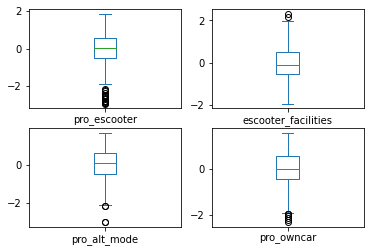

In [35]:
# box and whisker plots showing distributions of the factor scores of the 4 identified latent factors 

factor_score.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

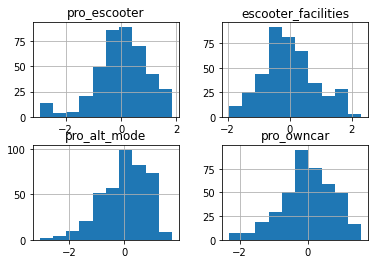

In [36]:
factor_score.hist()
plt.show()

In [37]:
#array to csv
#Score

# DF = pd.DataFrame(score)
# DF.to_csv("mob_score.csv")

In [38]:
#showing full values
#import sys
#import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

In [39]:
#score

# Step 2: Machine Learning Model

### Import packages and data

In [40]:
# Importing warning for ignore warnings 
import warnings
warnings.filterwarnings("ignore")

# Imports for visualizing Decision Tree
from sklearn.datasets import*
from sklearn.tree import*
from IPython.display import Image,display_svg,SVG
from dtreeviz.trees import dtreeviz
from sklearn import tree
from dtreeviz.trees import *

%matplotlib inline
# Imports Packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sklearn
import numpy as np
from sklearn import metrics

In [41]:
#Import Regression Algorithm
from sklearn.datasets import make_regression
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

In [42]:
#Load dataset
from pandas import read_csv
dataset = pd.read_csv('frequency.csv')

In [43]:
dataset.head()

,Escoot_Freq,Age,Hispanic_Latino,Black,White,Asian,Gender,Income,Mode_cost,Mode_time,...,job_per_HH,emp_hh_entropy,trip_prod_attr_ind,regional_diversity,HH_worker_job_index,road_density,intersection_density,reg_CI_employment,reg_CI_working,walk_index
0,2,22,1,0,1,0,2,5,1,1,...,0.952265,0.528482,0.470345,0.36039,0.369891,20.515874,85.974193,0.283048,0.380062,13.155172
1,1,22,1,0,1,0,2,5,1,1,...,0.952265,0.528482,0.470345,0.36039,0.369891,20.515874,85.974193,0.283048,0.380062,13.155172
2,2,22,1,0,1,0,2,5,1,1,...,0.952265,0.528482,0.470345,0.36039,0.369891,20.515874,85.974193,0.283048,0.380062,13.155172
3,1,15,1,0,1,0,2,2,1,1,...,0.952265,0.528482,0.470345,0.36039,0.369891,20.515874,85.974193,0.283048,0.380062,13.155172
4,1,15,1,0,1,0,2,2,1,1,...,0.952265,0.528482,0.470345,0.36039,0.369891,20.515874,85.974193,0.283048,0.380062,13.155172


In [44]:
dataset.columns

Index(['Escoot_Freq', 'Age', 'Hispanic_Latino', 'Black', 'White', 'Asian',
       'Gender', 'Income', 'Mode_cost', 'Mode_time', 'Mode_reliability',
       'Mode_comfort', 'Mode_safety', 'Mode_environment', 'Trans_Consider',
       'Trip_work', 'Trip_school', 'Trip_shopping', 'Trip_social',
       'Trip_Distance', 'Consider_Shared_Escooter', 'HH_Vehicle',
       'Drivers_License', 'HH_Size', 'Marital_single', 'Married',
       'Marital_Div_Sep', 'Detached_house', 'Townhouse', 'Apt_2_4unit',
       'Apt_5more_unit', 'Student', 'Emp_fulltime', 'Emp_parttime', 'Emp_self',
       'Emp_unemployed', 'Retired', 'Education', 'pro_escooter',
       'pro_esc_infrastructure', 'pro_alternate_mode', 'pro_owncar',
       'working_age_percent', 'zero_car_HH', 'one_car_HH', 'two_more_car_HH',
       'low_wage_worker', 'HH_density', 'population_density', 'emp_density',
       'activity_density', 'job_per_HH', 'emp_hh_entropy',
       'trip_prod_attr_ind', 'regional_diversity', 'HH_worker_job_index',
   

In [45]:
####Droping missing values rows

dataset.dropna(inplace=True)

In [46]:
#count missing value
print('The number of missing value on dataset:')
dataset.isna().sum()

The number of missing value on dataset:


Escoot_Freq             0
Age                     0
Hispanic_Latino         0
Black                   0
White                   0
                       ..
road_density            0
intersection_density    0
reg_CI_employment       0
reg_CI_working          0
walk_index              0
Length: 61, dtype: int64

In [47]:
# choice type distribution
print(dataset.groupby('Escoot_Freq').size())

Escoot_Freq
1    302
2     52
3     49
dtype: int64


### Crosstab

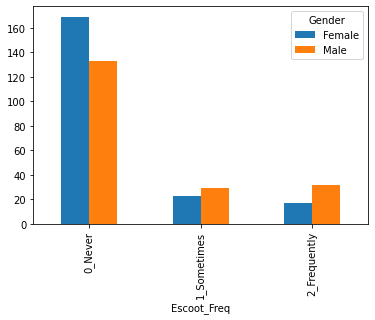

In [48]:
cross_tab_gen = pd.crosstab(dataset['Escoot_Freq'].replace([1, 2, 3], ["0_Never", "1_Sometimes", "2_Frequently"]), 
                            dataset['Gender'].replace([1, 2], ["Male", "Female"]))
cross_tab_gen.plot.bar()
plt.show()

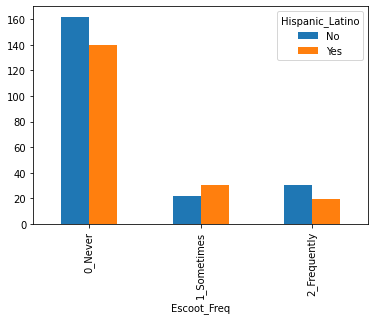

In [49]:
cross_tab_his = pd.crosstab(dataset['Escoot_Freq'].replace([1, 2, 3], ["0_Never", "1_Sometimes", "2_Frequently"]), 
                            dataset['Hispanic_Latino'].replace([0, 1], ["No", "Yes"]))
cross_tab_his.plot.bar()
plt.show()

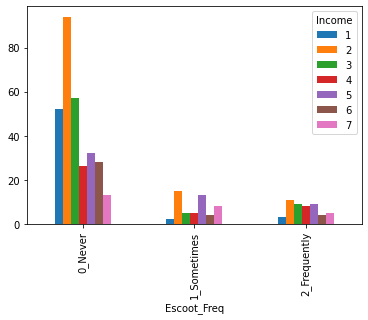

In [50]:
cross_tab_inc = pd.crosstab(dataset['Escoot_Freq'].replace([1, 2, 3], ["0_Never", "1_Sometimes", "2_Frequently"]), 
                            dataset['Income'])
cross_tab_inc.plot.bar()
plt.show()

### Recursive Feature Elimination (RFE)

Dimensionality reduction

In [51]:
# Normalizing Data
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
dataset.iloc[:, 1:] = ss.fit_transform(dataset.iloc[:, 1:])

In [52]:
# Data Split
array = dataset.values
X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, :1]

In [53]:
#importing SMote to make our dataset balanced
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,Y)

print('Original dataset shape', len(dataset))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 403
Resampled dataset shape 906


In [54]:
# Explore the number of selected features for RFE
from numpy import mean
from numpy import std

# from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

Model with Features: 1
MAE> 0.698 (0.071)
Model with Features: 2
MAE> 0.518 (0.057)
Model with Features: 3
MAE> 0.458 (0.047)
Model with Features: 4
MAE> 0.390 (0.038)
Model with Features: 5
MAE> 0.352 (0.041)
Model with Features: 6
MAE> 0.325 (0.035)
Model with Features: 7
MAE> 0.318 (0.036)
Model with Features: 8
MAE> 0.313 (0.032)
Model with Features: 9
MAE> 0.308 (0.033)
Model with Features: 10
MAE> 0.300 (0.035)
Model with Features: 11
MAE> 0.295 (0.034)
Model with Features: 12
MAE> 0.291 (0.032)
Model with Features: 13
MAE> 0.286 (0.032)
Model with Features: 14
MAE> 0.281 (0.031)
Model with Features: 15
MAE> 0.277 (0.029)
Model with Features: 16
MAE> 0.276 (0.029)
Model with Features: 17
MAE> 0.277 (0.030)
Model with Features: 18
MAE> 0.274 (0.028)
Model with Features: 19
MAE> 0.269 (0.031)
Model with Features: 20
MAE> 0.273 (0.027)
Model with Features: 21
MAE> 0.272 (0.029)
Model with Features: 22
MAE> 0.269 (0.028)
Model with Features: 23
MAE> 0.271 (0.026)
Model with Features:

No handles with labels found to put in legend.


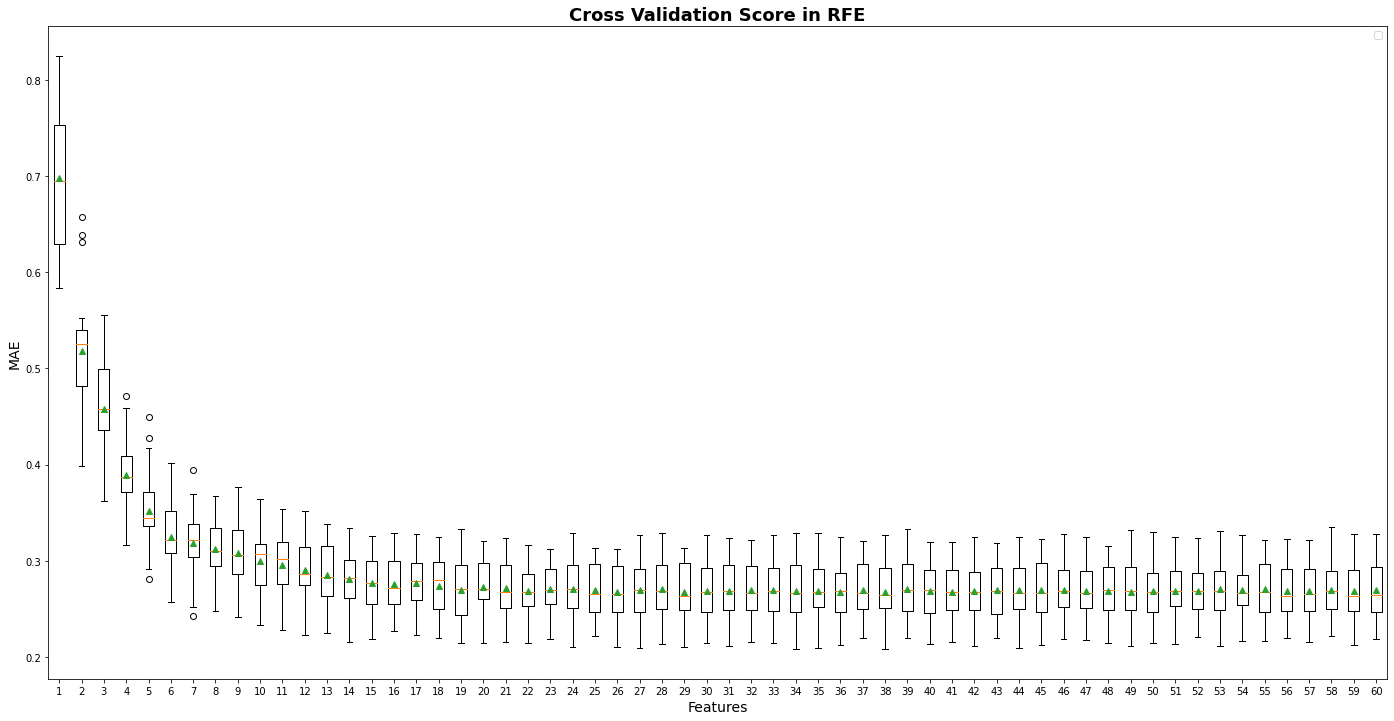

In [55]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,61):
        rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=i)
        model = RandomForestRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_smote, y_smote):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model,X_smote, y_smote, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return n_scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    print('Model with Features:', name)
    scores = abs(evaluate_model(model, X_smote, y_smote))
    results.append(scores)
    names.append(name)
    print('MAE> %.3f (%.3f)' % (mean(scores), std(scores)))
    
# plot model performance for comparison
plt.rcParams["figure.figsize"] = (24,12)
pyplot.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Features', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title("Cross Validation Score in RFE", fontsize=18, fontweight="bold")
plt.legend()
plt.savefig("RFE-CV-RFR_smote1.png", dpi=600, bbox_inches='tight')
pyplot.show()

In [56]:
# define RFE
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=26)
# fit RFE
rfe.fit(X, Y)
# summarize all features
for i in range(X.shape[1]):
    print('Feature:, %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Feature:, 0, Selected True, Rank: 1.000
Feature:, 1, Selected False, Rank: 3.000
Feature:, 2, Selected False, Rank: 21.000
Feature:, 3, Selected False, Rank: 24.000
Feature:, 4, Selected False, Rank: 35.000
Feature:, 5, Selected False, Rank: 17.000
Feature:, 6, Selected True, Rank: 1.000
Feature:, 7, Selected False, Rank: 8.000
Feature:, 8, Selected True, Rank: 1.000
Feature:, 9, Selected False, Rank: 11.000
Feature:, 10, Selected False, Rank: 14.000
Feature:, 11, Selected False, Rank: 10.000
Feature:, 12, Selected False, Rank: 15.000
Feature:, 13, Selected True, Rank: 1.000
Feature:, 14, Selected False, Rank: 23.000
Feature:, 15, Selected False, Rank: 25.000
Feature:, 16, Selected False, Rank: 18.000
Feature:, 17, Selected False, Rank: 19.000
Feature:, 18, Selected True, Rank: 1.000
Feature:, 19, Selected True, Rank: 1.000
Feature:, 20, Selected False, Rank: 4.000
Feature:, 21, Selected False, Rank: 34.000
Feature:, 22, Selected True, Rank: 1.000
Feature:, 23, Selected False, Rank: 26

In [57]:
#specifying 26 features to select to find the elemenated features
RFC = RFE(RandomForestRegressor(n_estimators=100, random_state=0), n_features_to_select= 26)
RFC.fit(X_smote, y_smote)

RFE(estimator=RandomForestRegressor(random_state=0), n_features_to_select=26)

In [58]:
RFC.get_support()

array([ True, False, False, False, False, False,  True,  True,  True,
        True,  True, False,  True,  True, False, False, False, False,
        True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False,  True, False,
       False, False, False, False, False,  True])

In [59]:
features = X_smote.columns[RFC.get_support()]
features

Index(['Age', 'Income', 'Mode_cost', 'Mode_time', 'Mode_reliability',
       'Mode_comfort', 'Mode_environment', 'Trans_Consider', 'Trip_Distance',
       'Consider_Shared_Escooter', 'HH_Vehicle', 'HH_Size', 'pro_escooter',
       'pro_esc_infrastructure', 'pro_alternate_mode', 'pro_owncar',
       'working_age_percent', 'zero_car_HH', 'one_car_HH', 'low_wage_worker',
       'HH_density', 'population_density', 'emp_density', 'job_per_HH',
       'trip_prod_attr_ind', 'walk_index'],
      dtype='object')

In [60]:
excluded_feature = list(set(X_smote.columns) - set(features))
print(excluded_feature)

['Emp_fulltime', 'Emp_parttime', 'Trip_school', 'Mode_safety', 'Trip_work', 'Marital_Div_Sep', 'HH_worker_job_index', 'Drivers_License', 'Asian', 'road_density', 'Apt_5more_unit', 'Marital_single', 'two_more_car_HH', 'Detached_house', 'Black', 'Education', 'Married', 'White', 'Retired', 'intersection_density', 'Hispanic_Latino', 'activity_density', 'Townhouse', 'Emp_unemployed', 'Apt_2_4unit', 'reg_CI_employment', 'Student', 'emp_hh_entropy', 'regional_diversity', 'reg_CI_working', 'Gender', 'Trip_social', 'Emp_self', 'Trip_shopping']


__Developing final ML algorithm using the identified important features from RFE__

In [61]:
# Normalizing Data 
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
scale_features = ['Age', 'Income', 'Mode_cost', 'Mode_time', 'Mode_reliability', 'Mode_comfort', 'Mode_environment', 
                  'Trans_Consider', 'Trip_Distance', 'Consider_Shared_Escooter', 'HH_Vehicle', 'HH_Size', 'pro_escooter',
                  'pro_esc_infrastructure', 'pro_alternate_mode', 'pro_owncar', 'working_age_percent', 'zero_car_HH', 
                  'one_car_HH', 'low_wage_worker', 'HH_density', 'population_density', 'emp_density', 'job_per_HH',
                  'trip_prod_attr_ind', 'walk_index']
dataset.loc[:, scale_features] = ss.fit_transform(dataset.loc[:, scale_features])

In [62]:
# # Data Split (RFE)
X = dataset.loc[:,['Age', 'Income', 'Mode_cost', 'Mode_time', 'Mode_reliability', 'Mode_comfort', 'Mode_environment', 
                  'Trans_Consider', 'Trip_Distance', 'Consider_Shared_Escooter', 'HH_Vehicle', 'HH_Size', 'pro_escooter',
                  'pro_esc_infrastructure', 'pro_alternate_mode', 'pro_owncar', 'working_age_percent', 'zero_car_HH', 
                  'one_car_HH', 'low_wage_worker', 'HH_density', 'population_density', 'emp_density', 'job_per_HH',
                  'trip_prod_attr_ind', 'walk_index']]

Y = dataset.loc[:,['Escoot_Freq']]

In [63]:
#importing SMote to make our dataset balanced
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,Y)

print('Original dataset shape', len(dataset))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 403
Resampled dataset shape 906


In [64]:
# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=1)

In [65]:
### Spot Check Algorithms
# models = []
# models.append(('DT', DecisionTreeRegressor()))
# models.append(('RF', RandomForestRegressor()))
# models.append(('XGB', XGBRegressor()))
# models.append(('KNR', KNeighborsRegressor()))
# models.append(('SVR', LinearSVR()))

In [66]:
### evaluate each model in turn, but only with training data set using 10-fold CV
# results = []
# names = []
# for name, model in models:
# 	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
# 	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_error')
# 	results.append(cv_results)
# 	names.append(name)
# 	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

In [67]:
### Compare Algorithms
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

Hyperparameter tuning

In [68]:
## Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter Grid
param_dict = {'learning_rate': [0.4, 0.3, 0.2, 0.15, 0.1, 0.05],
              'n_estimators' : [50, 100, 150, 200, 250],
              'max_depth' : [6, 8, 10, 15,20,25],
              'min_child_weight' : [1,3],
              'gamma': [0.3, 0.2, 0.1, 0],
              'min_samples_leaf' : [40, 50]}

In [142]:
xgb = XGBRegressor(random_state=42)

In [143]:
# Grid search
xgb_grid = RandomizedSearchCV(estimator=xgb,
                       param_distributions = param_dict,
                       n_jobs=-1, n_iter=5, cv = 10,
                       verbose=2, scoring='neg_mean_absolute_error')

In [144]:
# fitting model
xgb_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[15:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42,
        

In [145]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             min_samples_leaf=50, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, ...)

In [146]:
xgb_grid.best_params_

{'n_estimators': 250,
 'min_samples_leaf': 50,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 0}

In [147]:
model = xgb_grid.best_estimator_

In [148]:
model.fit(X_train, Y_train)

[15:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             min_samples_leaf=50, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, ...)

In [149]:
prediction = model.predict(X_test)

In [150]:
# evaluate regression model with k-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from numpy import absolute
from numpy import mean
from numpy import std

# define the evaluation procedure
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# evaluate the Prediction_Model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train, scoring= 'neg_mean_absolute_error', cv=cv, n_jobs=-1)
# cv_results = cross_val_score(model, X1_train, Y1_train, scoring= 'accuracy', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)

# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# print('Accuracy: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

MAE: 0.270 (0.036)


In [151]:
print('MAE:', metrics.mean_absolute_error(Y_test, prediction))
print('MSE:', metrics.mean_squared_error(Y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, prediction)))
print('R-Square:',metrics.r2_score(Y_test, prediction))
print('Explained variance:', metrics.explained_variance_score (Y_test, prediction))

MAE: 0.2706013200702248
MSE: 0.2157268534162951
RMSE: 0.4644640496489423
R-Square: 0.6848766849284988
Explained variance: 0.6851883424385176


In [154]:
import shap
import numpy as np
np.random.seed(42)
shap.initjs()
explainer = shap.TreeExplainer(model, random_state=42)
shap_values = explainer.shap_values(X_test)

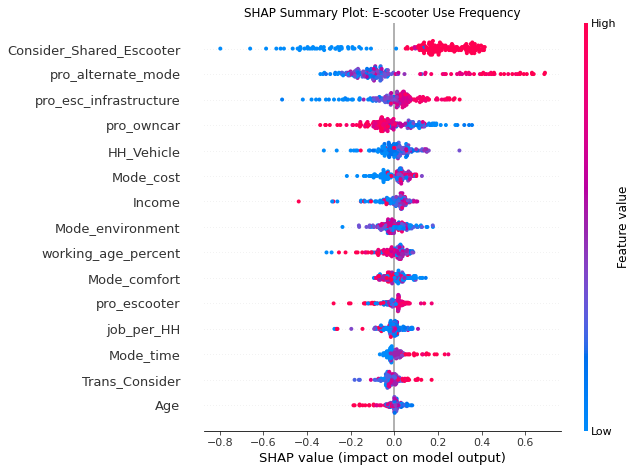

In [155]:
shap.summary_plot(shap_values, X_test, max_display = 15, show = False)
# plt.gcf()
plt.title("SHAP Summary Plot: E-scooter Use Frequency", fontsize="12")
plt.show()

## Exploratory data analysis

In [120]:
# !pip install Pyreadstat
## Import data: SPSS file
import pyreadstat

dataset1 = pd.read_spss("Micromobility_survey.sav")

In [121]:
# dataset1.head()

In [122]:
# dataset1.columns

__Proportion of e-scooter/moped trips used to connect to transit__

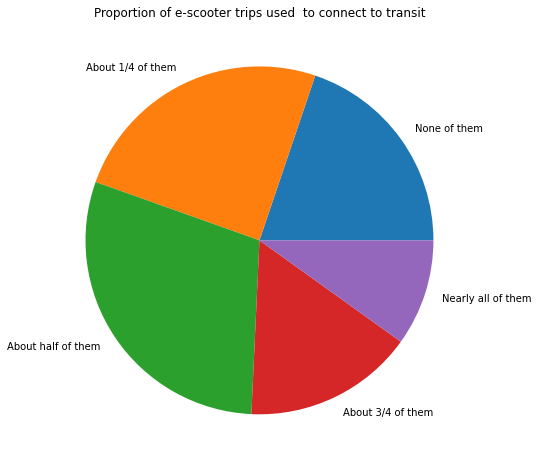

In [123]:
dataset1.A__Escoot___Trans = pd.Categorical(dataset1.A__Escoot___Trans, 
                                           categories=["None of them", "About 1/4 of them", "About half of them",
                                                      "About 3/4 of them", "Nearly all of them"], ordered=True)
dataset1.A__Escoot___Trans.value_counts(sort=False).plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Proportion of e-scooter trips used  to connect to transit")
plt.ylabel("")
plt.show()

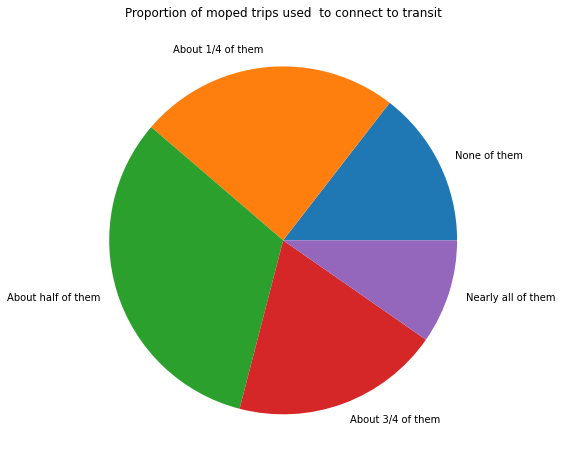

In [124]:
dataset1.A__Moped__Transiit = pd.Categorical(dataset1.A__Moped__Transiit, 
                                           categories=["None of them", "About 1/4 of them", "About half of them",
                                                      "About 3/4 of them", "Nearly all of them"], ordered=True)
dataset1.A__Moped__Transiit.value_counts(sort=False).plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Proportion of moped trips used  to connect to transit")
plt.ylabel("")
plt.show()

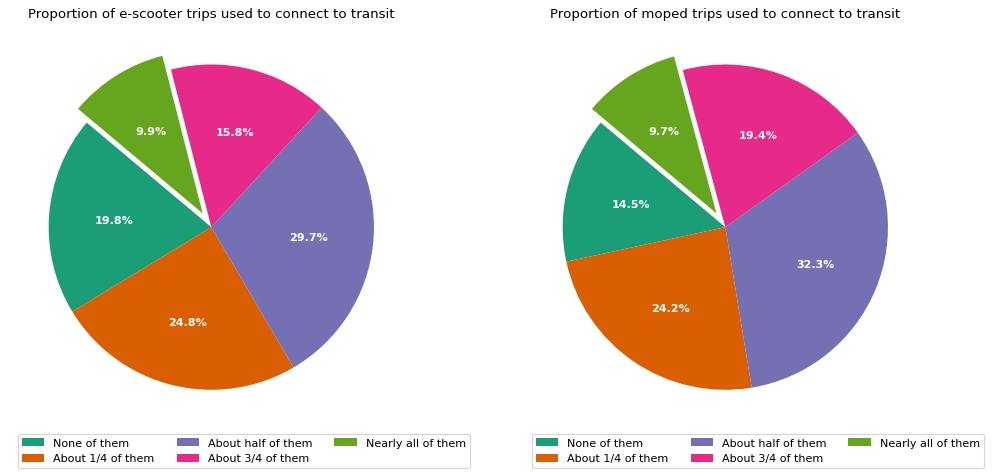

In [125]:
# Define the variables and their corresponding titles
variables = ['A__Escoot___Trans', 'A__Moped__Transiit']
titles = ['Proportion of e-scooter trips used to connect to transit',
          'Proportion of moped trips used to connect to transit']

# Create subplots
fig, axes = plt.subplots(1, len(variables), figsize=(13, 7), subplot_kw=dict(aspect="equal"), dpi=80)

for i, variable in enumerate(variables):
    # Prepare Data
    df = dataset1.groupby(variable).size().reset_index(name='counts')

    data = df['counts']
    categories = df[variable]
    explode = [0] * len(categories)
    explode[-1] = 0.1  # Explode the last slice

    wedges, texts, autotexts = axes[i].pie(data,
                                           autopct='%1.1f%%',
                                           textprops=dict(color="w"),
                                           colors=plt.cm.Dark2.colors,
                                           startangle=140,
                                           explode=explode)

    # Decoration
    axes[i].legend(wedges, categories, loc="center left", bbox_to_anchor=(0.01, -0.05), ncol=3)
    plt.setp(autotexts, size=10, weight=700)
    axes[i].set_title(titles[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

__Do you often carry passengers with you on the E-scooter/Moped?__

In [126]:
dataset1.Escooter_Passengers = pd.Categorical(dataset1.Escooter_Passengers, 
                                           categories=["Never", "Rarely", "Often", "Always"], ordered=True)

dataset1.Moped_Passengers = pd.Categorical(dataset1.Moped_Passengers, 
                                           categories=["Never", "Rarely", "Often", "Always"], ordered=True)

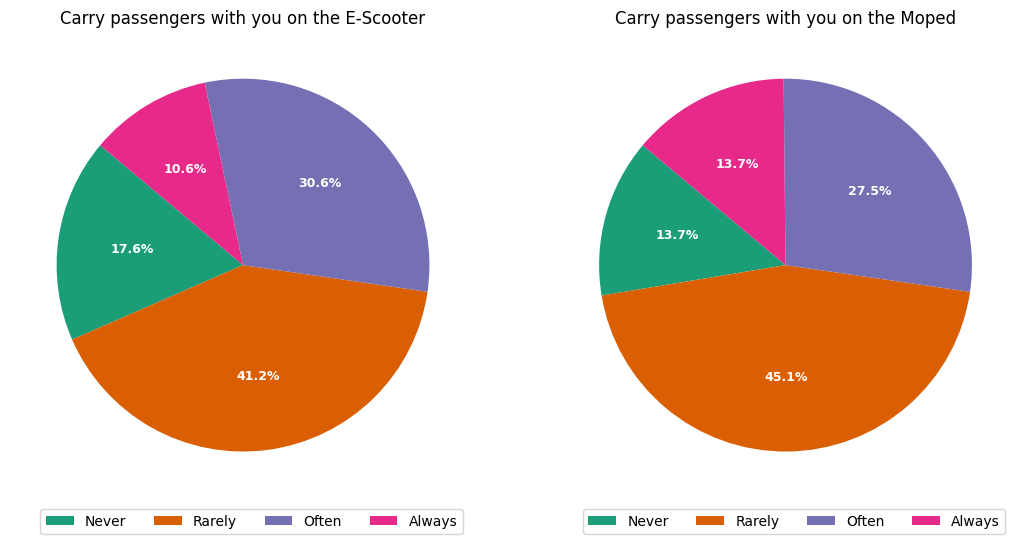

In [127]:
# Define the variables and their corresponding titles
variables = ['Escooter_Passengers', 'Moped_Passengers']
titles = ['Carry passengers with you on the E-Scooter', 'Carry passengers with you on the Moped']

# Create subplots
fig, axes = plt.subplots(1, len(variables), figsize=(11, 7), subplot_kw=dict(aspect="equal"), dpi=100)

for i, variable in enumerate(variables):
    # Prepare Data
    df = dataset1.groupby(variable).size().reset_index(name='counts')

    data = df['counts']
    categories = df[variable]

    wedges, texts, autotexts = axes[i].pie(data,
                                           autopct='%1.1f%%',
                                           textprops=dict(color="w"),
                                           colors=plt.cm.Dark2.colors,
                                           startangle=140)

    # Decoration
    axes[i].legend(wedges, categories, loc="center left", bbox_to_anchor=(0.05, -0.05), ncol=4)
    plt.setp(autotexts, size=9, weight=700)
    axes[i].set_title(titles[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

__How often do you wear a helmet while riding on the E-Scooter/Moped?__

In [128]:
dataset1.Helmet_Use_ES = pd.Categorical(dataset1.Helmet_Use_ES, 
                                           categories=["Never", "Rarely", "Often", "Always"], ordered=True)

dataset1.Helmet_Use_MO = pd.Categorical(dataset1.Helmet_Use_MO, 
                                           categories=["Never", "Rarely", "Often", "Always"], ordered=True)

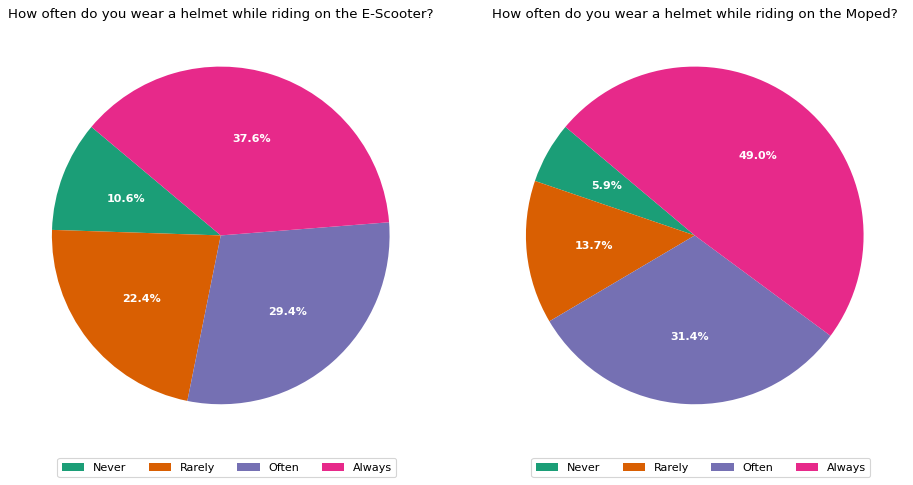

In [129]:
# Define the variables and their corresponding titles
variables = ['Helmet_Use_ES', 'Helmet_Use_MO']
titles = ['How often do you wear a helmet while riding on the E-Scooter?',
          'How often do you wear a helmet while riding on the Moped?']

# Create subplots
fig, axes = plt.subplots(1, len(variables), figsize=(12, 8), subplot_kw=dict(aspect="equal"), dpi=80)

for i, variable in enumerate(variables):
    # Prepare Data
    df = dataset1.groupby(variable).size().reset_index(name='counts')

    data = df['counts']
    categories = df[variable]

    wedges, texts, autotexts = axes[i].pie(data,
                                           autopct='%1.1f%%',
                                           textprops=dict(color="w"),
                                           colors=plt.cm.Dark2.colors,
                                           startangle=140)

    # Decoration
    axes[i].legend(wedges, categories, loc="center left", bbox_to_anchor=(0.1, -0.05), ncol=len(categories))
    plt.setp(autotexts, size=10, weight=700)
    axes[i].set_title(titles[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

__Intention to use shared e-scooter__

C:\Users\adib1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


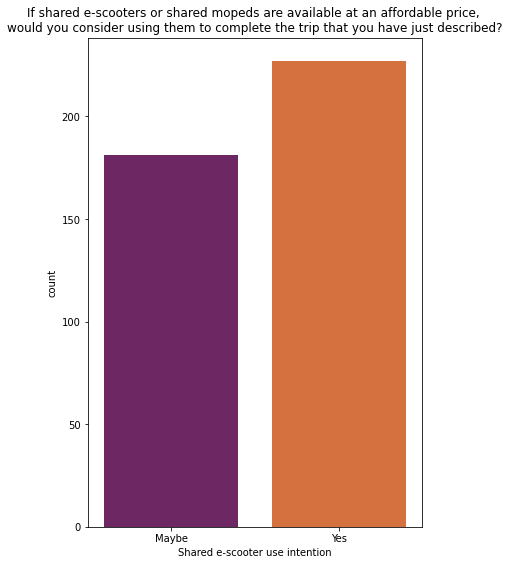

In [130]:
plt.rcParams['figure.figsize'] = (6, 9)

# plt.subplot(1, 2, 1)
sns.countplot(dataset1['Choice_Shared_Escoot'], palette = 'inferno')
plt.title("If shared e-scooters or shared mopeds are available at an affordable price, " 
          "\nwould you consider using them to complete the trip that you have just described?", fontsize = 12)
plt.xlabel('Shared e-scooter use intention', fontsize = 10)
plt.ylabel('count', fontsize = 10)


# checking the Distribution of customers on Weekend
# plt.subplot(1, 2, 2)
# sns.countplot(data['Weekend'], palette = 'inferno')
# plt.title('Purchase on Weekends', fontsize = 30)
# plt.xlabel('Weekend or not', fontsize = 15)
# plt.ylabel('count', fontsize = 15)

plt.show()

__How important is each of the following factors (Cost, Time, Reliability, Comfort, Safety, Environment) in selecting your mode of travel.__

In [131]:
# List of columns to apply categorical ordering
columns_to_order = dataset1.iloc[:, 36:42]

# Define the categories
categories = ["Not at all important", "Slightly important", 'Moderately important',
                                                        "Very important", "Extremely important"]

# apply categorical ordering 
for column in columns_to_order:
    dataset1[column] = pd.Categorical(dataset1[column], categories=categories, ordered=True)

# Print the updated dataset
# print(dataset)

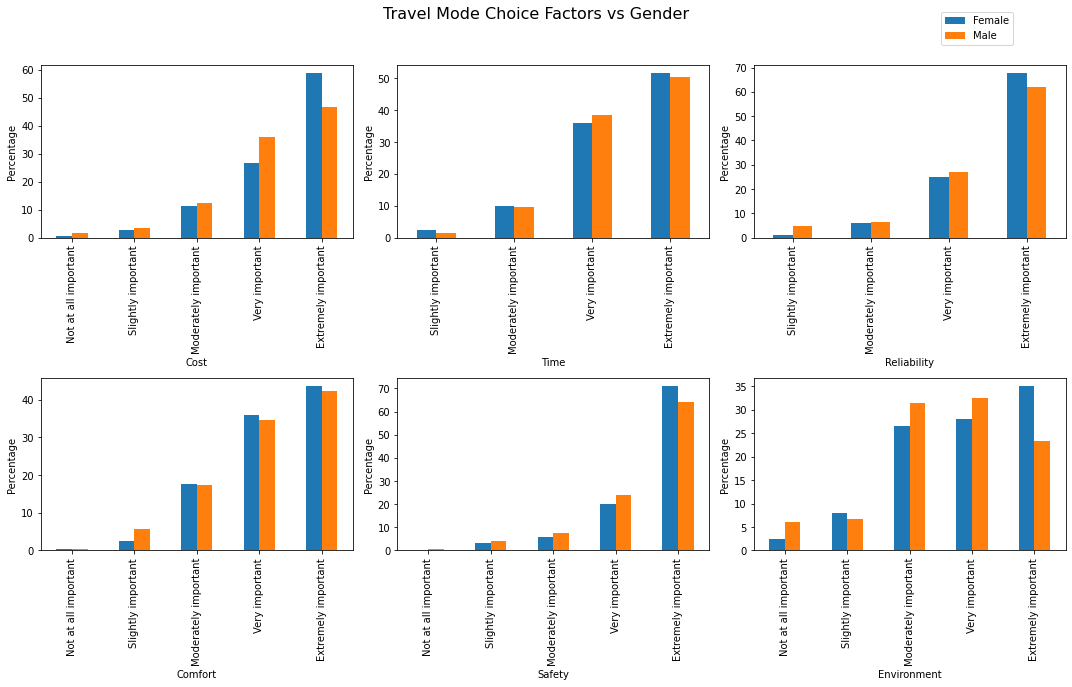

In [132]:
# List of columns 
columns_to_plot = dataset1.iloc[:, 36:42]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through columns and plot cross-tabulation
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    
    cross_tab = pd.crosstab(index=dataset1[column], columns=dataset1['Gender'], normalize='columns') * 100
#     ax = cross_tab.plot.bar(ax=axes[row, col], title=f'Cross-Tabulation of {column} by Gender')
    ax = cross_tab.plot.bar(ax=axes[row, col])
    ax.set_ylabel('Percentage')
    
    # Remove individual legends from each subplot
    ax.legend().set_visible(False)

# Create a single legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.87, 0.98))

# Add a single title to the entire subplot
plt.suptitle('Travel Mode Choice Factors vs Gender', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the suptitle

# Show the plot
plt.show()

In [133]:
column_index = dataset1.columns.get_loc('Cost')
column_index

36

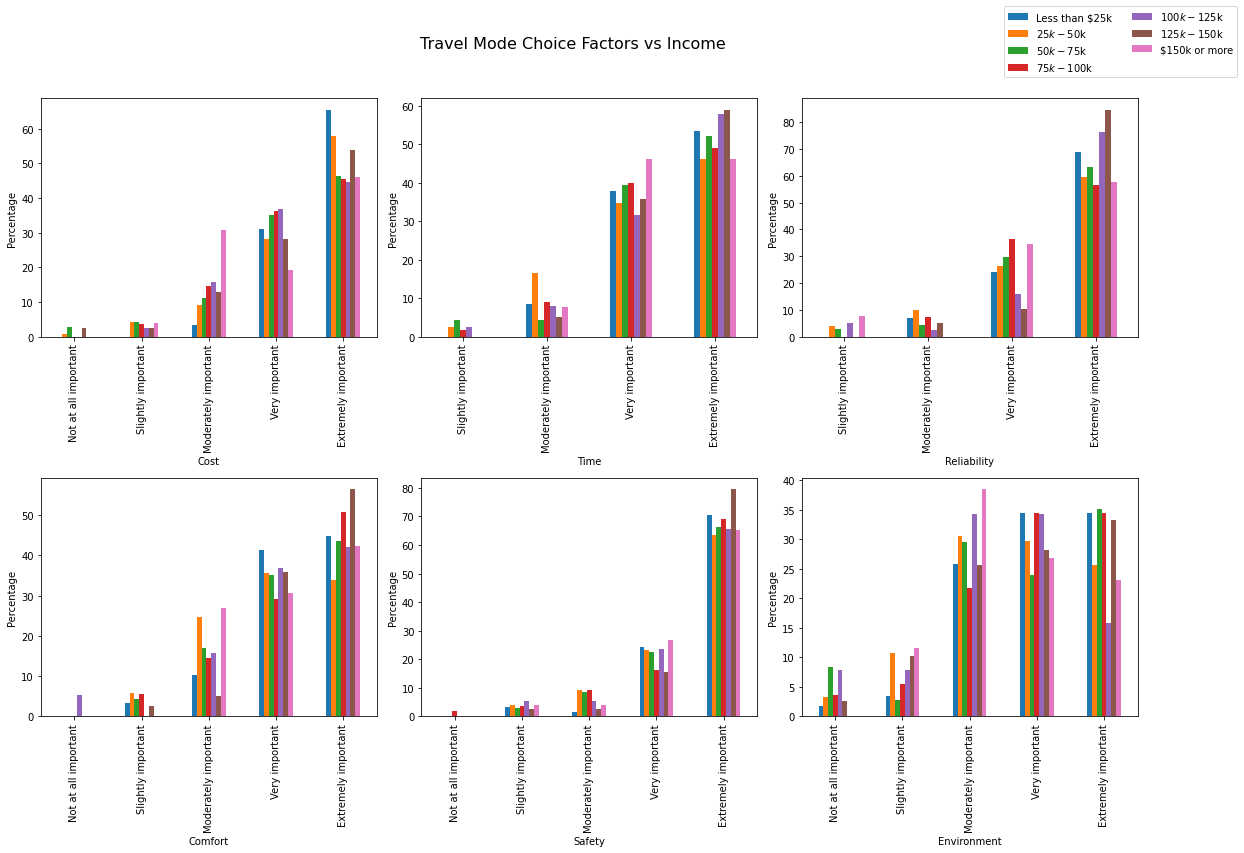

In [134]:
dataset1.Income = pd.Categorical(dataset1.Income, categories=["Less than $25k", "$25k - $50k", '$50k - $75k', '$75k - $100k',
                                                         "$100k - $125k", "$125k - $150k", "$150k or more"], ordered=True)
# List of columns 
columns_to_plot = dataset1.iloc[:, 36:42]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

# Loop through columns and plot cross-tabulation
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    
    cross_tab = pd.crosstab(index=dataset1[column], columns=dataset1['Income'], normalize='columns') * 100
    ax = cross_tab.plot.bar(ax=axes[row, col])
    ax.set_ylabel('Percentage')
    
    # Remove individual legends from each subplot
    ax.legend().set_visible(False)

# Create a single legend 
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.87, 1.02), ncol=2)

# Add a single title 
plt.suptitle('Travel Mode Choice Factors vs Income', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the suptitle

# Show the plot
plt.show()

__Transit, E-scooter, and Uber use frequency__

In [135]:
column_index = dataset1.columns.get_loc('Transit_use')
column_index

33

In [136]:
# List of columns 
columns_to_order = dataset1.iloc[:, 33:36]

# define the categories
categories = ["Never", "Once per month", 'Less than once per week', "1-2 times per week", 
              "3-4 times per week", "5 or more times per week"]

# categorical ordering 
for column in columns_to_order:
    dataset1[column] = pd.Categorical(dataset1[column], categories=categories, ordered=True)


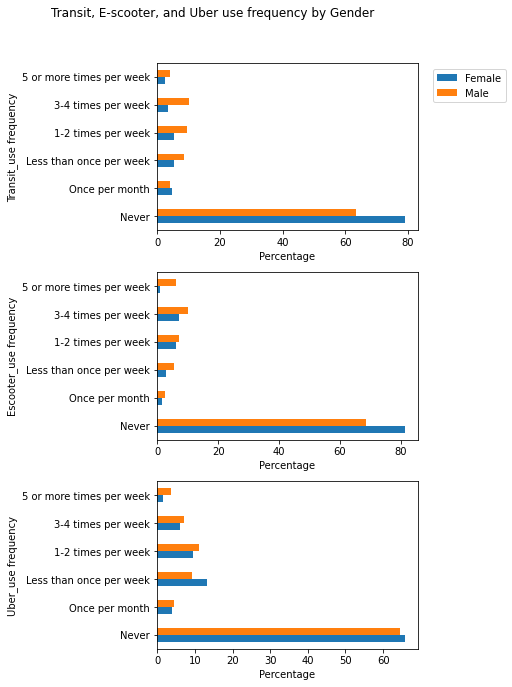

In [137]:
# List of columns 
columns_to_plot = dataset1.iloc[:, 33:36]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

# Loop through columns and plot cross-tabulation
for i, column in enumerate(columns_to_plot):
    row = i // 1
#     col = i % 2
    
    cross_tab = pd.crosstab(index=dataset1[column], columns=dataset1['Gender'], normalize='columns') * 100
#     ax = cross_tab.plot.barh(ax=axes[row], title=f'Cross-Tabulation of {column} by Gender')
    ax = cross_tab.plot.barh(ax=axes[row])
    ax.set_xlabel('Percentage')
    ax.set_ylabel(f'{column} frequency')
    
    # Remove individual legends from each subplot
    ax.legend().set_visible(False)

# Create a single legend 
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.90))

# Add a single title 
plt.suptitle('Transit, E-scooter, and Uber use frequency by Gender', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the suptitle

# Show the plot
plt.show()

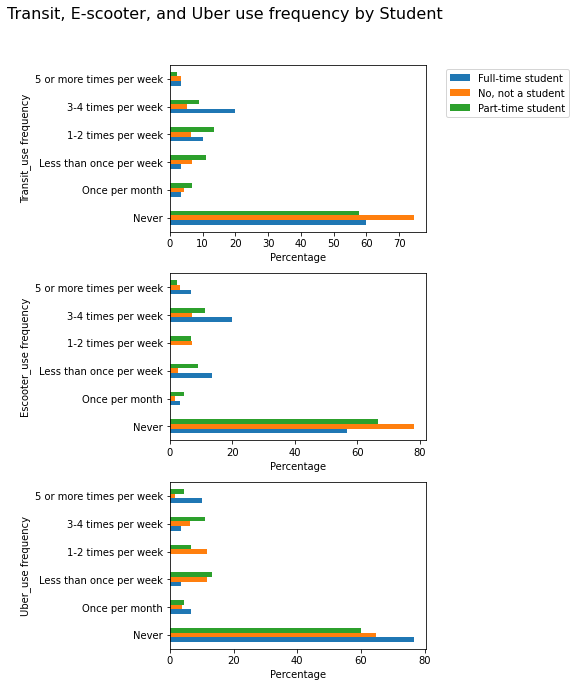

In [138]:
# List of columns to create cross-tabulations for
columns_to_plot = dataset1.iloc[:, 33:36]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

# Loop through columns and plot cross-tabulation
for i, column in enumerate(columns_to_plot):
    row = i // 1
#     col = i % 2
    
    cross_tab = pd.crosstab(index=dataset1[column], columns=dataset1['Student'], normalize='columns') * 100
#     ax = cross_tab.plot.barh(ax=axes[row], title=f'Cross-Tabulation of {column} by Gender')
    ax = cross_tab.plot.barh(ax=axes[row])
    ax.set_xlabel('Percentage')
    ax.set_ylabel(f'{column} frequency')
    
    # Remove individual legends from each subplot
    ax.legend().set_visible(False)

# Create a single legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.90))

# Add a single title to the entire subplot grid
plt.suptitle('Transit, E-scooter, and Uber use frequency by Student', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some space for the suptitle

# Show the plot
plt.show()

## Attitudes

__Attitudes regarding e-scooters and mobility options__

In [139]:
attitudes_escooter = dataset1.iloc[:, 42:48]
attitudes_esc_df = pd.DataFrame(attitudes_escooter)
attitudes_esc_df

,Escooter_Attitudes_1,Escooter_Attitudes_2,Escooter_Attitudes_3,Escooter_Attitudes_4,Escooter_Attitudes_5,Escooter_Attitudes_6
0,Agree,Agree,Agree,Agree,Agree,Strongly agree
1,Strongly agree,Neutral,Neutral,Strongly agree,Strongly agree,Neutral
2,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree
3,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree
4,Neutral,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Neutral
...,...,...,...,...,...,...
403,Disagree,Strongly disagree,Agree,Neutral,Agree,Neutral
404,Agree,Agree,Agree,Strongly agree,Strongly agree,Agree
405,Agree,Agree,Agree,Strongly agree,Strongly agree,Agree
406,Agree,Neutral,Strongly agree,Agree,Agree,Strongly agree


In [140]:
frequencies = {}
for i in attitudes_esc_df.columns:
    frequencies[i] = attitudes_esc_df[i].value_counts()
    
plotdata = pd.DataFrame(frequencies)
plotdata = plotdata.transpose()
plotdata 

,Agree,Disagree,Neutral,Strongly agree,Strongly disagree
Escooter_Attitudes_1,129,53,130,69,27
Escooter_Attitudes_2,130,91,93,65,29
Escooter_Attitudes_3,123,91,94,61,39
Escooter_Attitudes_4,170,24,99,91,24
Escooter_Attitudes_5,180,31,96,82,19
Escooter_Attitudes_6,128,56,125,73,26


In [141]:
plotdata2 = plotdata.div(plotdata.sum(axis=1), axis=0)*100
plotdata2 = pd.DataFrame(plotdata2)

index_labels = {'Escooter_Attitudes_1': 'Riding e-scooters is a safe way to get around',
                'Escooter_Attitudes_2': 'My city has enough bike lanes to accommodate e-scooter use',
                'Escooter_Attitudes_3': 'My city has enough space for proper e-scooter parking',
                'Escooter_Attitudes_4': 'The arrival of shared e-scooters is a good thing for the city',
                'Escooter_Attitudes_5': 'Shared e-scooters can strengthen the operations of public transit',
                'Escooter_Attitudes_6': 'Shared e-scooters will make people use transit less'}
plotdata2.rename(index=index_labels, inplace = True)
### order accordingly
re_order = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly agree']
plotdata2 = plotdata2[re_order]
plotdata2

,Strongly disagree,Disagree,Neutral,Agree,Strongly agree
Riding e-scooters is a safe way to get around,6.617647,12.990196,31.862745,31.617647,16.911765
My city has enough bike lanes to accommodate e-scooter use,7.107843,22.303922,22.794118,31.862745,15.931373
My city has enough space for proper e-scooter parking,9.558824,22.303922,23.039216,30.147059,14.950980
The arrival of shared e-scooters is a good thing for the city,5.882353,5.882353,24.264706,41.666667,22.303922
Shared e-scooters can strengthen the operations of public transit,4.656863,7.598039,23.529412,44.117647,20.098039
Shared e-scooters will make people use transit less,6.372549,13.725490,30.637255,31.372549,17.892157


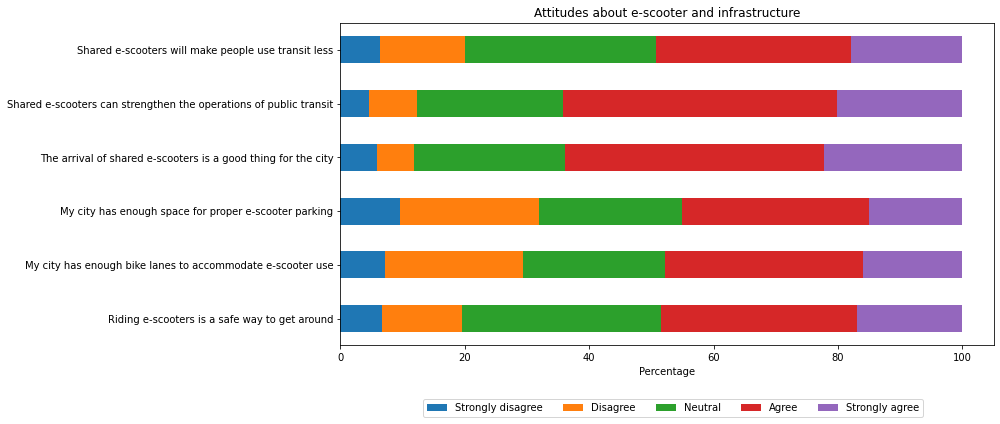

In [142]:
ax = plotdata2.plot(kind='barh', stacked=True, figsize=(14, 6))

legend1 = ax.legend(bbox_to_anchor=(0.9, -0.15), ncol=5)
# legend1_texts = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']
# for i, text in enumerate(legend1_texts):
#     legend1.get_texts()[i].set_text(text)

# ax.add_artist(legend1)
plt.title('Attitudes about e-scooter and infrastructure')
# plt.ylabel('Attitude statements')
plt.xlabel('Percentage')
plt.tight_layout()
plt.show()

In [143]:
attitudes_mobility = dataset1.iloc[:, 48:55]
attitudes_mob_df = pd.DataFrame(attitudes_mobility)
attitudes_mob_df

,Car_use_Attitudes_1,Car_use_Attitudes_2,Car_use_Attitudes_3,Car_use_Attitudes_4,Car_use_Attitudes_5,Car_use_Attitudes_6,Car_use_Attitudes_7
0,Neutral,Strongly agree,Agree,Agree,Strongly agree,Neutral,Agree
1,Strongly agree,Neutral,Neutral,Agree,Strongly agree,Strongly disagree,Neutral
2,Strongly agree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,Strongly disagree,Strongly agree
3,Neutral,Strongly agree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly agree
4,Neutral,Strongly agree,Neutral,Strongly agree,Strongly agree,Strongly disagree,Neutral
...,...,...,...,...,...,...,...
403,Disagree,Agree,Neutral,Neutral,Agree,Agree,Agree
404,Strongly disagree,Strongly agree,Disagree,Agree,Strongly agree,Strongly disagree,Strongly agree
405,Agree,Neutral,Agree,Neutral,Strongly agree,Strongly disagree,Agree
406,Strongly agree,Strongly agree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly agree


In [144]:
frequencies = {}
for i in attitudes_mob_df.columns:
    frequencies[i] = attitudes_mob_df[i].value_counts()
    
plotdata = pd.DataFrame(frequencies)
plotdata = plotdata.transpose()
plotdata 

,Agree,Disagree,Neutral,Strongly agree,Strongly disagree
Car_use_Attitudes_1,49,109,108,48,94
Car_use_Attitudes_2,142,21,78,154,13
Car_use_Attitudes_3,93,92,106,54,63
Car_use_Attitudes_4,126,69,115,63,35
Car_use_Attitudes_5,155,15,49,182,7
Car_use_Attitudes_6,77,100,81,42,108
Car_use_Attitudes_7,147,28,86,142,5


In [145]:
plotdata2 = plotdata.div(plotdata.sum(axis=1), axis=0)*100
plotdata2 = pd.DataFrame(plotdata2)

index_labels = {'Car_use_Attitudes_1': 'I hope to live without car',
                'Car_use_Attitudes_2': 'I definitely want to own a car',
                'Car_use_Attitudes_3': 'I try to use public transit whenever I can',
                'Car_use_Attitudes_4': 'I try to travel with non-motorized modes (biking and walking) as much as I can',
                'Car_use_Attitudes_5': 'I am confident in my ability to use new technologies (e.g., a smartphone app)',
                'Car_use_Attitudes_6': 'Learning how to use new technologies is often frustrating for me',
                'Car_use_Attitudes_7': 'I would rather own things than rent them'}
plotdata2.rename(index=index_labels, inplace = True)
### order accordingly
re_order = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly agree']
plotdata2 = plotdata2[re_order]
plotdata2

,Strongly disagree,Disagree,Neutral,Agree,Strongly agree
I hope to live without car,23.039216,26.715686,26.470588,12.009804,11.764706
I definitely want to own a car,3.186275,5.147059,19.117647,34.803922,37.745098
I try to use public transit whenever I can,15.441176,22.549020,25.980392,22.794118,13.235294
I try to travel with non-motorized modes (biking and walking) as much as I can,8.578431,16.911765,28.186275,30.882353,15.441176
"I am confident in my ability to use new technologies (e.g., a smartphone app)",1.715686,3.676471,12.009804,37.990196,44.607843
Learning how to use new technologies is often frustrating for me,26.470588,24.509804,19.852941,18.872549,10.294118
I would rather own things than rent them,1.225490,6.862745,21.078431,36.029412,34.803922


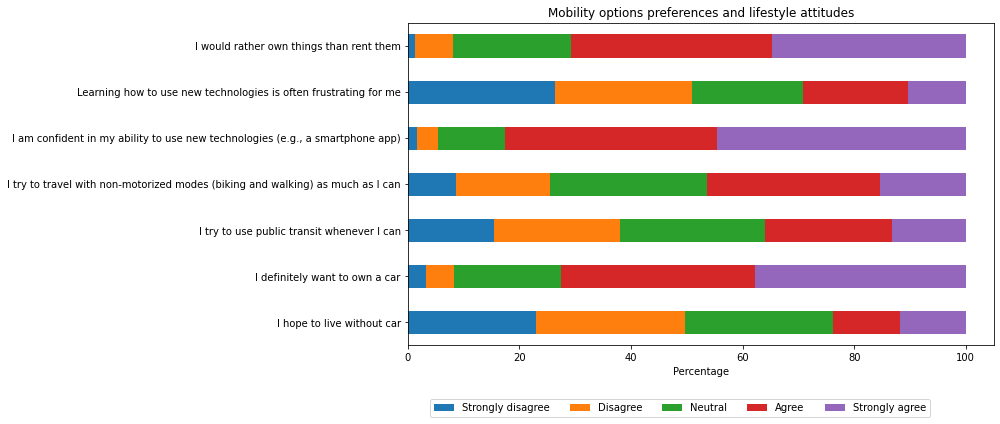

In [146]:
ax = plotdata2.plot(kind='barh', stacked=True, figsize=(14, 6))

legend1 = ax.legend(bbox_to_anchor=(0.9, -0.15), ncol=5)
# legend1_texts = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']
# for i, text in enumerate(legend1_texts):
#     legend1.get_texts()[i].set_text(text)

# ax.add_artist(legend1)
plt.title('Mobility options preferences and lifestyle attitudes')
# plt.ylabel('Attitude statements')
plt.xlabel('Percentage')
plt.tight_layout()
plt.show()

In [147]:
column_index = dataset1.columns.get_loc('Escooter_Attitudes_1')
column_index

42